In [1]:
#Filename: HW4_skeleton.py
#Author: Christian Knoll, Florian Kaum
#Edited: May, 2018

import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.spatial import distance

from scipy.stats import multivariate_normal

#--------------------------------------------------------------------------------
# Assignment 4
def main():
    
    # choose the scenario
#     scenario = 1    # all anchors are Gaussian
    #scenario = 2    # 1 anchor is exponential, 3 are Gaussian
    scenario = 3    # all anchors are exponential
    
    # specify position of anchors
    p_anchor = np.array([[5,5],[-5,5],[-5,-5],[5,-5]])
    nr_anchors = np.size(p_anchor,0)
    
    # position of the agent for the reference mearsurement
    p_ref = np.array([[0,0]])
    # true position of the agent (has to be estimated)
    p_true = np.array([[2,-4]])
#    p_true = np.array([[2,-4])
                       
    plot_anchors_and_agent(nr_anchors, p_anchor, p_true, p_ref)
    
    # load measured data and reference measurements for the chosen scenario
    data,reference_measurement = load_data(scenario)
    
    # get the number of measurements 
    assert(np.size(data,0) == np.size(reference_measurement,0))
    nr_samples = np.size(data,0)
    
    #1) ML estimation of model parameters
    #TODO 
    params = parameter_estimation(reference_measurement,nr_anchors,p_anchor,p_ref)
    
    #2) Position estimation using least squares
    #TODO
    position_estimation_least_squares(data,nr_anchors,p_anchor, p_true, True)

    if(scenario == 3):
        # TODO: don't forget to plot joint-likelihood function for the first measurement

        #3) Postion estimation using numerical maximum likelihood
        #TODO
        position_estimation_numerical_ml(data,nr_anchors,p_anchor, params, p_true)
    
        #4) Position estimation with prior knowledge (we roughly know where to expect the agent)
        #TODO
        # specify the prior distribution
        prior_mean = p_true
        prior_cov = np.eye(2)
        position_estimation_bayes(data,nr_anchors,p_anchor,prior_mean,prior_cov, params, p_true)
    print(params)

    pass

#--------------------------------------------------------------------------------
#--------------------------------------------------------------------------------
def parameter_estimation(reference_measurement,nr_anchors,p_anchor,p_ref):
    """ estimate the model parameters for all 4 anchors based on the reference measurements, i.e., for anchor i consider reference_measurement[:,i]
    Input:
        reference_measurement... nr_measurements x nr_anchors
        nr_anchors... scalar
        p_anchor... position of anchors, nr_anchors x 2
        p_ref... reference point, 2x2 """
    params = np.zeros([1, nr_anchors])
    #TODO (1) check whether a given anchor is Gaussian or exponential
    distr_array = np.zeros(nr_anchors)
    baseline = np.sqrt(50)
    
    for measurement in range(0, nr_anchors):
        comp = np.where(reference_measurement[:, measurement] >= baseline)
        if len(comp[0]) == reference_measurement.shape[0]:
            distr_array[measurement] = 1
    #TODO (2) estimate the according parameter based
    gaus_indexes = np.where(distr_array == 0)
    exp_indexes = np.where(distr_array == 1)
    
    if gaus_indexes[0].shape[0] > 0:
        dim_gaus = reference_measurement[:,gaus_indexes[0]].shape[0] * reference_measurement[:,gaus_indexes[0]].shape[1]
        gaus_data = np.reshape(reference_measurement[:,gaus_indexes[0]], dim_gaus)
        gaus_sigma = np.sum(np.power((gaus_data - baseline), 2)) / dim_gaus
        params[0,gaus_indexes[0]] = gaus_sigma

        
    if exp_indexes[0].shape[0] > 0:
        dim_exp = reference_measurement[:,exp_indexes[0]].shape[0] * reference_measurement[:,exp_indexes[0]].shape[1]
        exp_data = np.reshape(reference_measurement[:,exp_indexes[0]], dim_exp)
        exp_lambda = dim_exp / (np.sum(exp_data - baseline))
        params[0, exp_indexes[0]] = exp_lambda
    
    return params
#--------------------------------------------------------------------------------
def position_estimation_least_squares(data,nr_anchors,p_anchor, p_true, use_exponential):
    """estimate the position by using the least squares approximation. 
    Input:
        data...distance measurements to unkown agent, nr_measurements x nr_anchors
        nr_anchors... scalar
        p_anchor... position of anchors, nr_anchors x 2 
        p_true... true position (needed to calculate error) 2x2 
        use_exponential... determines if the exponential anchor in scenario 2 is used, bool"""
    nr_samples = np.size(data,0)
    
    #TODO set parameters
    tol = 1e-6  # tolerance
    max_iter = 10  # maximum iterations for GN
    p_start = np.random.uniform(-5,5, [2])
    
    # TODO estimate position for  i in range(0, nr_samples)
    for row in range(0, nr_samples):
        r = data[row,:]
        least_squares_GN(p_anchor,p_start, r, max_iter, tol)
	# TODO calculate error measures and create plots----------------
    pass
#--------------------------------------------------------------------------------
def position_estimation_numerical_ml(data,nr_anchors,p_anchor, lambdas, p_true):
    """ estimate the position by using a numerical maximum likelihood estimator
    Input:
        data...distance measurements to unkown agent, nr_measurements x nr_anchors
        nr_anchors... scalar
        p_anchor... position of anchors, nr_anchors x 2 
        lambdas... estimated parameters (scenario 3), nr_anchors x 1
        p_true... true position (needed to calculate error), 2x2 """
    #TODO
    pass
#--------------------------------------------------------------------------------
def position_estimation_bayes(data,nr_anchors,p_anchor,prior_mean,prior_cov,lambdas, p_true):
    """ estimate the position by accounting for prior knowledge that is specified by a bivariate Gaussian
    Input:
         data...distance measurements to unkown agent, nr_measurements x nr_anchors
         nr_anchors... scalar
         p_anchor... position of anchors, nr_anchors x 2
         prior_mean... mean of the prior-distribution, 2x1
         prior_cov... covariance of the prior-dist, 2x2
         lambdas... estimated parameters (scenario 3), nr_anchors x 1
         p_true... true position (needed to calculate error), 2x2 """
    # TODO
    pass
#--------------------------------------------------------------------------------
def least_squares_GN(p_anchor,p_start, r, max_iter, tol):
    """ apply Gauss Newton to find the least squares solution
    Input:
        p_anchor... position of anchors, nr_anchors x 2
        p_start... initial position, 2x1
        r... distance_estimate, nr_anchors x 1
        max_iter... maximum number of iterations, scalar
        tol... tolerance value to terminate, scalar"""
    nr_anchors = p_anchor.shape
    Jd = np.zeros([nr_anchors[0], nr_anchors[1]])
    distances = np.zeros([4])
    
    for iter in range(0, max_iter):
        for row in range(0,nr_anchors[0]):
            Jd[row,0] =np.power( (np.power((p_anchor[row, 0] - p_start[0]),2) 
                                  + np.power((p_anchor[row, 1] - p_start[1]),2)),-0.5) * (p_anchor[row, 0] - p_start[0])
            
            Jd[row,1] =np.power( (np.power((p_anchor[row, 0] - p_start[0]),2) 
                                  + np.power((p_anchor[row, 1] - p_start[1]),2)),-0.5) * (p_anchor[row, 1] - p_start[1])

            distances[row] = distance.euclidean(p_anchor[row,:],p_start.T)
        p_start = p_start - np.dot(np.dot(np.linalg.inv(np.dot(Jd.T, Jd)), Jd.T),(r - distances))
    
    
    pass
    
#--------------------------------------------------------------------------------
#--------------------------------------------------------------------------------
# Helper Functions
#--------------------------------------------------------------------------------
def plot_gauss_contour(mu,cov,xmin,xmax,ymin,ymax,title="Title"):
    
    """ creates a contour plot for a bivariate gaussian distribution with specified parameters
    
    Input:
      mu... mean vector, 2x1
      cov...covariance matrix, 2x2
      xmin,xmax... minimum and maximum value for width of plot-area, scalar
      ymin,ymax....minimum and maximum value for height of plot-area, scalar
      title... title of the plot (optional), string"""
    
	#npts = 100
    delta = 0.025
    x = np.arange(xmin, xmax, delta)
    y = np.arange(ymin, ymax, delta)
    X, Y = np.meshgrid(x, y)
    Z = mlab.bivariate_normal(X,Y,np.sqrt(cov[0][0]),np.sqrt(cov[1][1]),mu[0], mu[1], cov[0][1])
    plt.plot([mu[0]],[mu[1]],'r+') # plot the mean as a single point
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title(title)
    plt.show()
    return

#--------------------------------------------------------------------------------
def ecdf(realizations):   
    """ computes the empirical cumulative distribution function for a given set of realizations.
    The output can be plotted by plt.plot(x,Fx)
    
    Input:
      realizations... vector with realizations, Nx1
    Output:
      x... x-axis, Nx1
      Fx...cumulative distribution for x, Nx1"""
    x = np.sort(realizations)
    Fx = np.linspace(0,1,len(realizations))
    return Fx,x

#--------------------------------------------------------------------------------
def load_data(scenario):
    """ loads the provided data for the specified scenario
    Input:
        scenario... scalar
    Output:
        data... contains the actual measurements, nr_measurements x nr_anchors
        reference.... contains the reference measurements, nr_measurements x nr_anchors"""
    data_file = 'measurements_' + str(scenario) + '.data'
    ref_file =  'reference_' + str(scenario) + '.data'
    
    data = np.loadtxt(data_file,skiprows = 0)
    reference = np.loadtxt(ref_file,skiprows = 0)
    
    return (data,reference)
#--------------------------------------------------------------------------------
def plot_anchors_and_agent(nr_anchors, p_anchor, p_true, p_ref=None):
    """ plots all anchors and agents
    Input:
        nr_anchors...scalar
        p_anchor...positions of anchors, nr_anchors x 2
        p_true... true position of the agent, 2x1
        p_ref(optional)... position for reference_measurements, 2x1"""
    # plot anchors and true position
    plt.axis([-6, 6, -6, 6])
    for i in range(0, nr_anchors):
        plt.plot(p_anchor[i, 0], p_anchor[i, 1], 'bo')
        plt.text(p_anchor[i, 0] + 0.2, p_anchor[i, 1] + 0.2, r'$p_{a,' + str(i) + '}$')
    plt.plot(p_true[0, 0], p_true[0, 1], 'r*')
    plt.text(p_true[0, 0] + 0.2, p_true[0, 1] + 0.2, r'$p_{true}$')
    if p_ref is not None:
        plt.plot(p_ref[0, 0], p_ref[0, 1], 'r*')
        plt.text(p_ref[0, 0] + 0.2, p_ref[0, 1] + 0.2, '$p_{ref}$')
    plt.xlabel("x/m")
    plt.ylabel("y/m")
    plt.show()
    pass

#--------------------------------------------------------------------------------
#--------------------------------------------------------------------------------
if __name__ == '__main__':
    main()


<Figure size 640x480 with 1 Axes>

OSError: measurements_3.data not found.

In [2]:
p_start

NameError: name 'p_start' is not defined

In [3]:
print(pate)

NameError: name 'pate' is not defined

In [100]:
rows = np.arange(-5, 5.05, 0.05)
coordinates = np.zeros([200,200])
coordinates = [(i,j) for j in rows for i in rows]
coordinates = np.array(coordinates)
coordinates.shape

wtf = np.meshgrid(rows,rows)
wtf = np.array(wtf)
print(wtf.shape)
distance.euclidean(wtf[:, 20,20], wtf[:, 5,5])

(2, 201, 201)


1.0606601717798174

In [98]:
shaize = np.random.rand(3,3)
print(shaize)

ind = np.unravel_index(np.argmax(shaize, axis=None), shaize.shape)
print(ind)
type(ind)
shaize[ind]

[[0.48163208 0.66851395 0.65628152]
 [0.25473229 0.88112592 0.74176481]
 [0.05154506 0.5802633  0.67122776]]
(1, 1)


0.8811259234768416

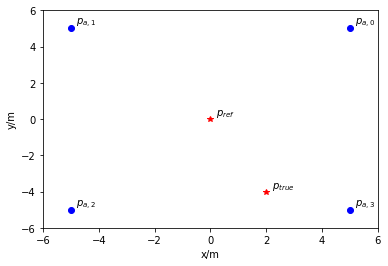

OSError: measurements_3.data not found.

In [103]:
# choose the scenario
# scenario = 1    # all anchors are Gaussian
# scenario = 2    # 1 anchor is exponential, 3 are Gaussian
scenario = 3  # all anchors are exponential

# specify position of anchors
p_anchor = np.array([[5, 5], [-5, 5], [-5, -5], [5, -5]])
nr_anchors = np.size(p_anchor, 0)

# position of the agent for the reference mearsurement
p_ref = np.array([[0, 0]])
# true position of the agent (has to be estimated)
p_true = np.array([[2, -4]])
#    p_true = np.array([[2,-4])

plot_anchors_and_agent(nr_anchors, p_anchor, p_true, p_ref)

# load measured data and reference measurements for the chosen scenario
data, reference_measurement = load_data(scenario)

# get the number of measurements
assert (np.size(data, 0) == np.size(reference_measurement, 0))
nr_samples = np.size(data, 0)

# 1) ML estimation of model parameters
# TODO
params = parameter_estimation(reference_measurement, nr_anchors, p_anchor, p_ref)

# 2) Position estimation using least squares
# TODO
# position_estimation_least_squares(data, nr_anchors, p_anchor, p_true, True)

if (scenario == 2):
    p_anchor = np.array([[-5, 5], [-5, -5], [5, -5]])
    nr_anchors = np.size(p_anchor, 0)
    position_estimation_least_squares(data[:, 1:4], nr_anchors, p_anchor, p_true, True)

if (scenario == 3):
    # TODO: don't forget to plot joint-likelihood function for the first measurement

    # 3) Postion estimation using numerical maximum likelihood
    # TODO
    position_estimation_numerical_ml(data, nr_anchors, p_anchor, params, p_true)

    # 4) Position estimation with prior knowledge (we roughly know where to expect the agent)
    # TODO
    # specify the prior distribution
    prior_mean = p_true
    prior_cov = np.eye(2)
    position_estimation_bayes(data, nr_anchors, p_anchor, prior_mean, prior_cov, params, p_true)

In [102]:
def position_estimation_data_point(data_point, nr_anchors, p_anchor, lambdas):
    rows = np.arange(-5, 5.05, 0.05)
    grid = np.meshgrid(rows, rows)
    grid = np.array(grid)
    jt_likehood = np.zeros([ rows.shape[0],rows.shape[0] ])
    distances = np.zeros([nr_anchors])
    likehood = np.zeros([nr_anchors])

    for x_coord in range(0, grid.shape[1]):
        for y_coord in range(0, grid.shape[2]):
            temp_point = grid[:, x_coord, y_coord]
            for anch in range(0, nr_anchors):
                distances[anch] = distance.euclidean(temp_point, p_anchor[anch, :])
                likehood[anch] = lambdas[anch]*np.exp(-lambdas[anch] * (data_point[anch] - distances[anch]))
            jt_likehood[x_coord, y_coord] = np.prod(likehood)

    ind = np.unravel_index(np.argmax(jt_likehood, axis=None), jt_likehood.shape)
    # p_est = jt_likehood[ind]
    coords_max = grid[:,ind]
    print(coords_max)
    return

In [8]:
dim = reference_measurement[:,gaus_indexes[0]].shape[0] * reference_measurement[:,gaus_indexes[0]].shape[1]
gaus_data = np.reshape(reference_measurement[:,gaus_indexes[0]], dim)


In [9]:
dim = reference_measurement[:,exp_indexes[0]].shape[0] * reference_measurement[:,exp_indexes[0]].shape[1]
exp_data = np.reshape(reference_measurement[:,exp_indexes[0]], dim)


In [10]:
params = np.zeros([1, nr_anchors])
print(gaus_indexes[0])
params[0,gaus_indexes[0]] = gaus_sigma
params[0, exp_indexes[0]] = exp_lambda
params

[1 2 3]


NameError: name 'gaus_sigma' is not defined

In [ ]:
gaus_indexes = np.where(distr_array == 0)
exp_indexes = np.where(distr_array == 1)

if gaus_indexes[0].shape[0] > 0:
    dim_gaus = reference_measurement[:,gaus_indexes[0]].shape[0] * reference_measurement[:,gaus_indexes[0]].shape[1]
    gaus_data = np.reshape(reference_measurement[:,gaus_indexes[0]], dim_gaus)
    gaus_sigma = np.sum(np.power((gaus_data - baseline), 2)) / dim_gaus

if exp_indexes[0].shape[0] > 0:
    dim_exp = reference_measurement[:,exp_indexes[0]].shape[0] * reference_measurement[:,exp_indexes[0]].shape[1]
    exp_data = np.reshape(reference_measurement[:,exp_indexes[0]], dim_exp)
    exp_lambda = dim_exp / (np.sum(exp_data - baseline))
    
gaus_sigma

In [ ]:

if gaus_indexes[0].shape[0] > 0:
    dim_gaus = reference_measurement[:,gaus_indexes[0]].shape[0] * reference_measurement[:,gaus_indexes[0]].shape[1]
    gaus_data = np.reshape(reference_measurement[:,gaus_indexes[0]], dim_gaus)
    gaus_sigma = np.sum(np.power((gaus_data - baseline), 2)) / dim_gaus
    params[0,gaus_indexes[0]] = gaus_sigma

        
if exp_indexes[0].shape[0] > 0:
    dim_exp = reference_measurement[:,exp_indexes[0]].shape[0] * reference_measurement[:,exp_indexes[0]].shape[1]
    exp_data = np.reshape(reference_measurement[:,exp_indexes[0]], dim_exp)
    exp_lambda = dim_exp / (np.sum(exp_data - baseline))
    params[0, exp_indexes[0]] = exp_lambda
        
params

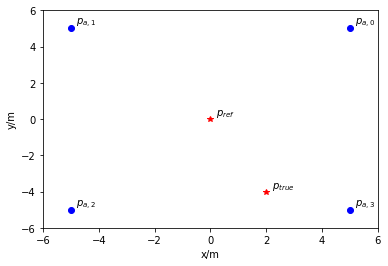

TypeError: data type not understood

In [60]:
main()

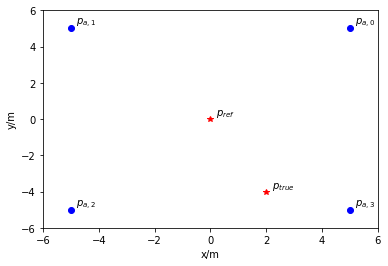

TypeError: 'float' object cannot be interpreted as an integer

In [69]:
# choose the scenario
#     scenario = 1    # all anchors are Gaussian
#scenario = 2    # 1 anchor is exponential, 3 are Gaussian
scenario = 3    # all anchors are exponential

# specify position of anchors
p_anchor = np.array([[5,5],[-5,5],[-5,-5],[5,-5]])
nr_anchors = np.size(p_anchor,0)

# position of the agent for the reference mearsurement
p_ref = np.array([[0,0]])
# true position of the agent (has to be estimated)
p_true = np.array([[2,-4]])
#    p_true = np.array([[2,-4])

plot_anchors_and_agent(nr_anchors, p_anchor, p_true, p_ref)

# load measured data and reference measurements for the chosen scenario
data,reference_measurement = load_data(scenario)

# get the number of measurements 
assert(np.size(data,0) == np.size(reference_measurement,0))
nr_samples = np.size(data,0)

#1) ML estimation of model parameters
#TODO 
params = parameter_estimation(reference_measurement,nr_anchors,p_anchor,p_ref)

#2) Position estimation using least squares
#TODO
position_estimation_least_squares(data,nr_anchors,p_anchor, p_true, True)

if(scenario == 3):
    # TODO: don't forget to plot joint-likelihood function for the first measurement

    #3) Postion estimation using numerical maximum likelihood
    #TODO
    position_estimation_numerical_ml(data,nr_anchors,p_anchor, params, p_true)

    #4) Position estimation with prior knowledge (we roughly know where to expect the agent)
    #TODO
    # specify the prior distribution
    prior_mean = p_true
    prior_cov = np.eye(2)
    position_estimation_bayes(data,nr_anchors,p_anchor,prior_mean,prior_cov, params, p_true)

In [84]:
nr_samples = np.size(data,0)

#TODO set parameters
tol = 1e-6  # tolerance
max_iter = 1000  # maximum iterations for GN
p_start = np.random.uniform(-5,5, [2])

# TODO estimate position for  i in range(0, nr_samples)
for row in range(0, nr_samples):
    r = data[row,:]
    least_squares_GN(p_anchor,p_start, r, max_iter, tol)
# TODO calculate error measures and create plots----------------

ValueError: operands could not be broadcast together with shapes (2,4) (4,2) 

(4, 1)

In [111]:

p_start = p_start - np.dot(np.dot(np.linalg.inv(np.dot(Jd.T, Jd)), Jd.T),(r - distances))
p